## Project 2 

### Titanic - Automated Feature Engineering Test

The steps are almost identical as it was in previous notebook.

Roadmap:

- Understand the Data
- Importing libraries
- Load the data
- Data cleaning
- Describe the prediction problem
- Building the entityset
- DFS
- Evaluating the model


#### Step 1 - Importing Libraries

In [32]:
import pandas as pd
#import autosklearn.classification
import featuretools as ft
from featuretools.primitives import *
from featuretools.variable_types import Numeric
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input"))

['gender_submission.csv', 'test.csv', 'train.csv']


#### Step 2 - Loading Data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
test_y = pd.read_csv('../input/gender_submission.csv')

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


#### Step 4 - Data Cleaning

It is necessary to clean the data. Wee will apply the code of feature cleaning taken from one of existing Kernels - Best Titanic Survival Prediction for Beginners, where an interested reader can find a very detailed explanation of each steps of the data cleaning procedure.

In [4]:
# combining train set with test set
combine = train_df.append(test_df)

passenger_id=test_df['PassengerId'] # attribute passengerId to passenger_id variable


#combine.drop(['PassengerId'], axis=1, inplace=True)
combine = combine.drop(['Ticket', 'Cabin'], axis=1) # dropping unnecessary columns
# filling empty spaces
combine.Fare.fillna(combine.Fare.mean(), inplace=True) 
# Normalization of Sex
combine['Sex'] = combine.Sex.apply(lambda x: 0 if x == "female" else 1) 
#RegEx for name Extraction
for name_string in combine['Name']:
    combine['Title']=combine['Name'].str.extract('([A-Za-z]+)\.',expand=True) 
    
#replacing the rare title with more common one.
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
combine.replace({'Title': mapping}, inplace=True)

combine = combine.drop(['Name'], axis=1)

#adding median age for null in Age column
titles=['Mr','Miss','Mrs','Master','Rev','Dr']
for title in titles:
    age_to_impute = combine.groupby('Title')['Age'].median()[titles.index(title)]
    combine.loc[(combine['Age'].isnull()) & (combine['Title'] == title), 'Age'] = age_to_impute
combine.isnull().sum()

#dropping empty on 
freq_port = train_df.Embarked.dropna().mode()[0]
combine['Embarked'] = combine['Embarked'].fillna(freq_port)
    
combine['Embarked'] = combine['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
combine['Title'] = combine['Title'].map( {'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Rev': 4, 'Dr': 5} ).astype(int)
combine.fillna(0, inplace=True)

In [5]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
Age            1309 non-null float64
Embarked       1309 non-null int64
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       1309 non-null float64
Title          1309 non-null int64
dtypes: float64(3), int64(7)
memory usage: 112.5 KB


#### Step 5 -  Describing the prediction problem.

It is simply a survival rate of the passengers. It is either that passenger died or survived the accident. It is described in our data survived = 1, died = 0

#### Step 6 - Building Entityset

In [23]:
datfr=combine.drop(['Survived'], axis=1)

def make_entityset(data):
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='combine',
                             variable_types = 
                             {
                                 'Embarked': ft.variable_types.Categorical,
                                 'Sex': ft.variable_types.Boolean,
                                 'Title': ft.variable_types.Categorical
                             },
                              index = 'PassengerId')
    es.normalize_entity(base_entity_id='combine', 
                        new_entity_id='Embarked', 
                        index='Embarked')
    es.normalize_entity(base_entity_id='combine', 
                        new_entity_id='Sex', 
                        index='Sex')
    es.normalize_entity(base_entity_id='combine', 
                        new_entity_id='Title', 
                        index='Title')
    es.normalize_entity(base_entity_id='combine', 
                        new_entity_id='Pclass', 
                        index='Pclass')
    es.normalize_entity(base_entity_id='combine', 
                        new_entity_id='Parch', 
                        index='Parch')
    es.normalize_entity(base_entity_id='combine', 
                        new_entity_id='SibSp', 
                        index='SibSp')
    return es
es = make_entityset(datfr)
es

Entityset: Dataset
  Entities:
    combine [Rows: 1309, Columns: 9]
    Embarked [Rows: 3, Columns: 1]
    Sex [Rows: 2, Columns: 1]
    Title [Rows: 6, Columns: 1]
    Pclass [Rows: 3, Columns: 1]
    Parch [Rows: 8, Columns: 1]
    SibSp [Rows: 7, Columns: 1]
  Relationships:
    combine.Embarked -> Embarked.Embarked
    combine.Sex -> Sex.Sex
    combine.Title -> Title.Title
    combine.Pclass -> Pclass.Pclass
    combine.Parch -> Parch.Parch
    combine.SibSp -> SibSp.SibSp

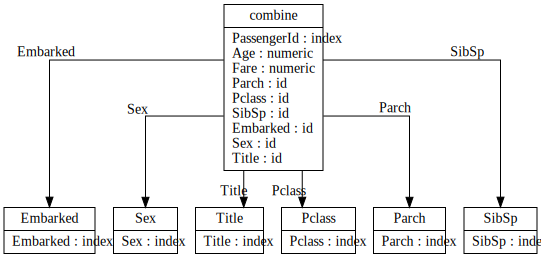

In [24]:
es.plot()

#### Step 4 - Deep Feature Synthesis

In [35]:
features, feature_names = ft.dfs(entityset=es, 
                      target_entity='combine',
                      agg_primitives=['last', 'max', 'min'],
                      trans_primitives=[],
                      max_depth=2,
                      verbose=True)


Built 74 features
Elapsed: 00:04 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Step 5 - Feature Reduction and Selection

In [36]:
threshold = 0.95

# Absolute value correlation matrix
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head(50)

Age      Fare     Parch    Pclass     SibSp  \
Age                            NaN  0.105971  0.164063  0.285575  0.225064   
Fare                           NaN       NaN  0.221522  0.558477  0.160224   
Parch                          NaN       NaN       NaN  0.018322  0.373587   
Pclass                         NaN       NaN       NaN       NaN  0.060832   
SibSp                          NaN       NaN       NaN       NaN       NaN   
Embarked                       NaN       NaN       NaN       NaN       NaN   
Sex                            NaN       NaN       NaN       NaN       NaN   
Title                          NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.Age)     NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.Fare)    NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.Parch)   NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.Pclass)  NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.SibSp)   NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.Sex)     NaN       NaN       NaN       NaN       NaN   
Embarked.LAST(combine.Title)   NaN       NaN       NaN       NaN       NaN   
Embarked.MAX(combine.Age)      NaN       NaN       NaN       NaN       NaN   
Embarked.MAX(combine.Fare)     NaN       NaN       NaN       NaN       NaN   
Embarked.MIN(combine.Age)      NaN       NaN       NaN       NaN       NaN   
Embarked.MIN(combine.Fare)     NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.Age)          NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.Fare)         NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.Parch)        NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.Pclass)       NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.SibSp)        NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.Embarked)     NaN       NaN       NaN       NaN       NaN   
Sex.LAST(combine.Title)        NaN       NaN       NaN       NaN       NaN   
Sex.MAX(combine.Age)           NaN       NaN       NaN       NaN       NaN   
Sex.MAX(combine.Fare)          NaN       NaN       NaN       NaN       NaN   
Sex.MIN(combine.Age)           NaN       NaN       NaN       NaN       NaN   
Sex.MIN(combine.Fare)          NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.Age)        NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.Fare)       NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.Parch)      NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.Pclass)     NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.SibSp)      NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.Embarked)   NaN       NaN       NaN       NaN       NaN   
Title.LAST(combine.Sex)        NaN       NaN       NaN       NaN       NaN   
Title.MAX(combine.Age)         NaN       NaN       NaN       NaN       NaN   
Title.MAX(combine.Fare)        NaN       NaN       NaN       NaN       NaN   
Title.MIN(combine.Age)         NaN       NaN       NaN       NaN       NaN   
Title.MIN(combine.Fare)        NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.Age)       NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.Fare)      NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.Parch)     NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.SibSp)     NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.Embarked)  NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.Sex)       NaN       NaN       NaN       NaN       NaN   
Pclass.LAST(combine.Title)     NaN       NaN       NaN       NaN       NaN   
Pclass.MAX(combine.Age)        NaN       NaN       NaN       NaN       NaN   
Pclass.MAX(combine.Fare)       NaN       NaN       NaN       NaN       NaN   

                               Embarked       Sex   

In [37]:
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 28 features to remove.


In [38]:
features_filtered = features.drop(columns = collinear_features)

print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])

The number of features that passed the collinearity threshold:  46


In [39]:
features_positive = features_filtered.loc[:, features_filtered.ge(0).all()]

train_X = features_positive[:train_df.shape[0]]
train_y = train_df['Survived']

test_X = features_positive[train_df.shape[0]:]

In [40]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_X, train_y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(train_X)
X_selected_df = pd.DataFrame(X_new, columns=[train_X.columns[i] for i in range(len(train_X.columns)) if model.get_support()[i]])
X_selected_df.shape

(891, 16)

#### Step 6 - Evaluating the model

In [66]:
random_forest = RandomForestClassifier(n_estimators=2000,oob_score=True)
random_forest.fit(X_selected_df, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [53]:
Y_pred = random_forest.predict(test_X[X_selected_df.columns])

In [50]:
Y_pred.shape

(418,)

In [55]:
answers2 = test_y.drop(['PassengerId'], axis=1)

In [56]:
#reg = RandomForestRegressor(n_estimators=1000)
#reg.fit(X_train, y_train)
    
#preds = reg.predict(X_selected_df)
scores = mean_absolute_error(Y_pred, answers2)
print('Mean Abs Error: {:.2f}'.format(scores))

Mean Abs Error: 0.20


In [61]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

random_accy = round(accuracy_score(Y_pred, answers2), 3)
print (random_accy)
print(precision_score(answers2,Y_pred))
print(recall_score(answers2,Y_pred))
print(confusion_matrix(answers2,Y_pred))

0.804
0.7108433734939759
0.7763157894736842
[[218  48]
 [ 34 118]]


#### Conclusion

Using same steps as in previous notebook we reached very nice score straight out of the box.